# CGU Math 381 (Image Processing), Spring'18 - Homework #2

#### Edge detection, sharpening, the Total Variation norm, and histogram equalization
##### Due on Tuesday 3/6, at the begining of class 
##### Zhengming Song

##### **Problem 2.1** (Contrast Enhancement)

##### **Anwser:**

The trasformation function $s=T(r)$ can be defined mathematically as follow:
$$ 
s=T(r) =
\begin{cases}
s = \frac{s_1}{r_1} r, & 0\le r < r_1\\
s = \frac{s_2-s_1}{r_2-r_1}(r-r_1)+s_1, & r_1 \le r <r_2 \\
s = \frac{s_2-(L-1)}{r_2-(L-1)}(r-(L-1))+(L-1), & r_2 \le r \le L-1
\end{cases},
s\in [0, L-1], r \in [0, L-1]
$$


In [1]:
# Implementation
def transform(r, r1,s1,r2,s2, L):
    if r<0: # handle inputs outside of support
        return 0;
    elif r>=0 and r<r1:
        return r*s1/r1
    elif r>= r1 and r< r2:
        return (r-r1)*(s2-s1)/(r2-r1)+s1
    elif r>=r2 and r<=L-1:
        return (r-(L-1))*(s2-(L-1))/(r2-(L-1)) + (L-1)
    else: # handle inputs outside of support
        return L-1

In [2]:
import numpy as np
r = np.linspace(0, 255, 255)
s = np.array([transform(v, 96, 32, 160, 224, 256) for v in r])

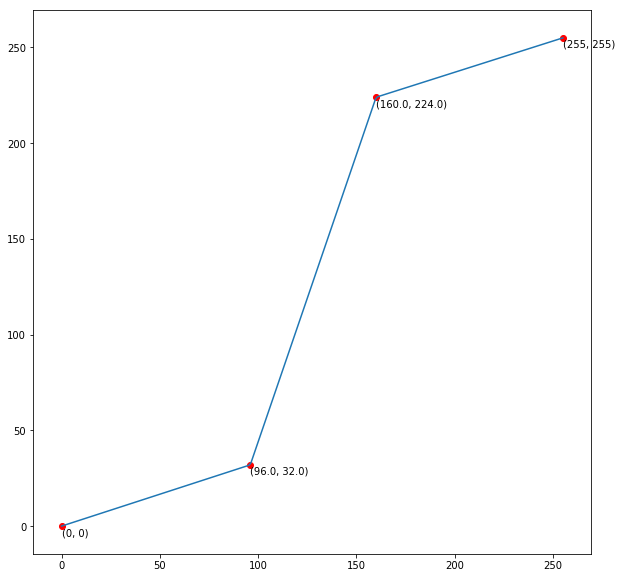

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
L = 256
plt.figure(figsize=(10,10))
plt.plot(r,s)
plt.scatter([0, 3*L/8, 5*L/8, L-1],[0, L/8, 7*L/8, L-1],c='red')
for x,y in zip([0, 3*L/8, 5*L/8, L-1],[0, L/8, 7*L/8, L-1]):
    plt.annotate('('+ str(x)+', '+str(y)+')', (x,y-5))


##### **Problem 2.2** (More on isotropy)


##### **Answer:**

Borrow the notations from hw1, that is, we choose an arbitrary 
angle $\theta$ and operate the change of 
coordinates $T:(x,y)\mapsto(u,v)$ given by the transformation: 
$$
T:
\left\{
\begin{array}{ccl}
x(u,v) & = & u\cos\theta - v \sin\theta \\
y(u,v) & = & u\sin\theta + v \cos\theta 
\end{array}
\right.
\qquad
\Longleftrightarrow
\qquad
T^{-1}:
\left\{
\begin{array}{ccl}
u(x,y) & = & x\cos\theta + y \sin\theta \\
v(x,y) & = & -x\sin\theta + y \cos\theta 
\end{array}
\right.
$$ 

let $f(x,y) = F(u(x,y), v(x,y))$

\begin{eqnarray}
\frac{\partial F}{\partial u} &= \frac{\partial F}{\partial x}\frac{\partial x}{\partial u} + \frac{\partial F}{\partial y}\frac{\partial y}{\partial u}\\
&= \frac{\partial F}{\partial x}\cos \theta + \frac{\partial F}{\partial y}\sin \theta
\end{eqnarray}


\begin{eqnarray}
\frac{\partial F}{\partial v} &= \frac{\partial F}{\partial x}\frac{\partial x}{\partial v} + \frac{\partial F}{\partial y}\frac{\partial y}{\partial v}\\
&= -\frac{\partial F}{\partial x}\sin \theta + \frac{\partial F}{\partial y}\cos \theta
\end{eqnarray}


(a). 

\begin{eqnarray}
||\nabla F(u,v)|| &= \sqrt{(\frac{\partial F}{\partial u})^2 + (\frac{\partial F}{\partial v})^2} \\
&= \sqrt{(\frac{\partial F}{\partial x}\cos \theta + \frac{\partial F}{\partial y}\sin \theta)^2 + (-\frac{\partial F}{\partial x}\sin \theta + \frac{\partial F}{\partial y}\cos \theta)^2}\\
&= \sqrt{((\frac{\partial F}{\partial x})^2 \cos^2 \theta + 2(\frac{\partial F}{\partial x})(\frac{\partial F}{\partial y})\cos \theta \sin \theta + (\frac{\partial F}{\partial y})^2 \sin^2 \theta) + ((\frac{\partial F}{\partial x})^2 \sin^2 \theta - 2(\frac{\partial F}{\partial x})(\frac{\partial F}{\partial y})\cos \theta \sin \theta + (\frac{\partial F}{\partial y})^2 \cos^2 \theta) }\\
&= \sqrt{(\frac{\partial F}{\partial x})^2 (\cos^2 \theta + \sin^2 \theta) + (\frac{\partial F}{\partial y})^2 (\sin^2 \theta + \cos^2 \theta)}\\
&= \sqrt{(\frac{\partial f}{\partial x})^2 + (\frac{\partial f}{\partial y})^2}\\
&= ||\nabla f(x,y)||
\end{eqnarray}


Hence, the first operation is isotropic. 

(b).

\begin{eqnarray}
||\nabla F(u,v)|| &= |\frac{\partial F}{\partial u}| + |\frac{\partial F}{\partial v}| \\
&= |\frac{\partial F}{\partial x}\cos \theta + \frac{\partial F}{\partial y}\sin \theta| + |-\frac{\partial F}{\partial x}\sin \theta + \frac{\partial F}{\partial y}\cos \theta|\\
&<= |\frac{\partial F}{\partial x}\cos \theta| + |\frac{\partial F}{\partial y}\sin \theta| + |\frac{\partial F}{\partial x}\sin \theta| + |\frac{\partial F}{\partial y}\cos \theta|\\
&\ne |\frac{\partial f}{\partial x}| + |\frac{\partial f}{\partial y}| = ||\nabla f(x,y)||
\end{eqnarray}


Hence, the second operation is **not** isotropic.

##### **Problem 2.3** (Edge detection)

##### **Anwser:**

(a). 

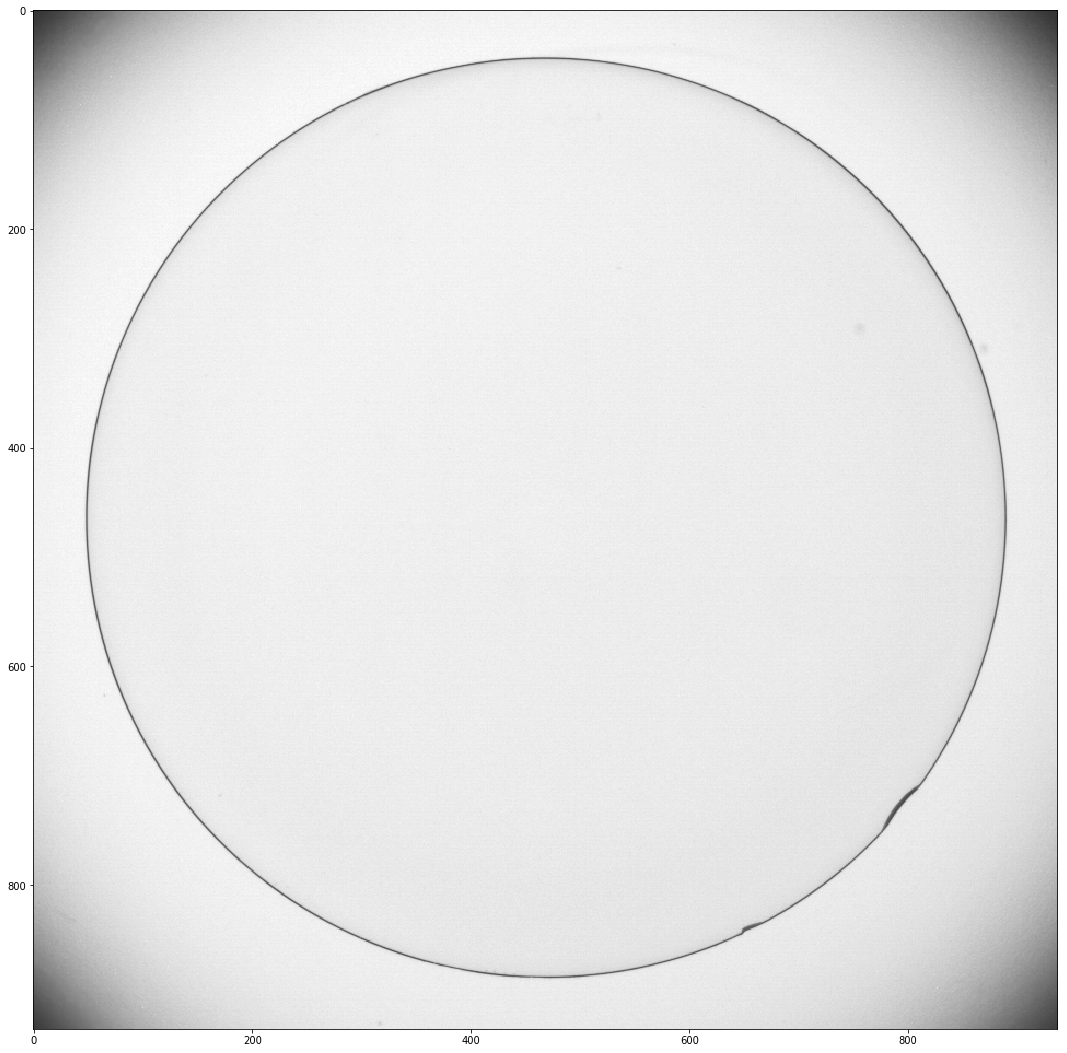

In [4]:
from PIL import Image
import scipy.misc
from matplotlib import cm
from scipy import ndimage

# reading original image
a = Image.open('Math386-HW2-Images/image-contactlens.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# plotting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

In [5]:
def defineImage(I):
    # prevent grey level values outside of [0, 255]
    return np.array([[max(0,min(255,j))for j in i] for i in I])

def enhanceImage(I):
    # threshold of enhancement
    t = 0.33 * np.max(I)
    return np.array([[255 if c>t else 0 for c in r] for r in I], dtype=np.int32)

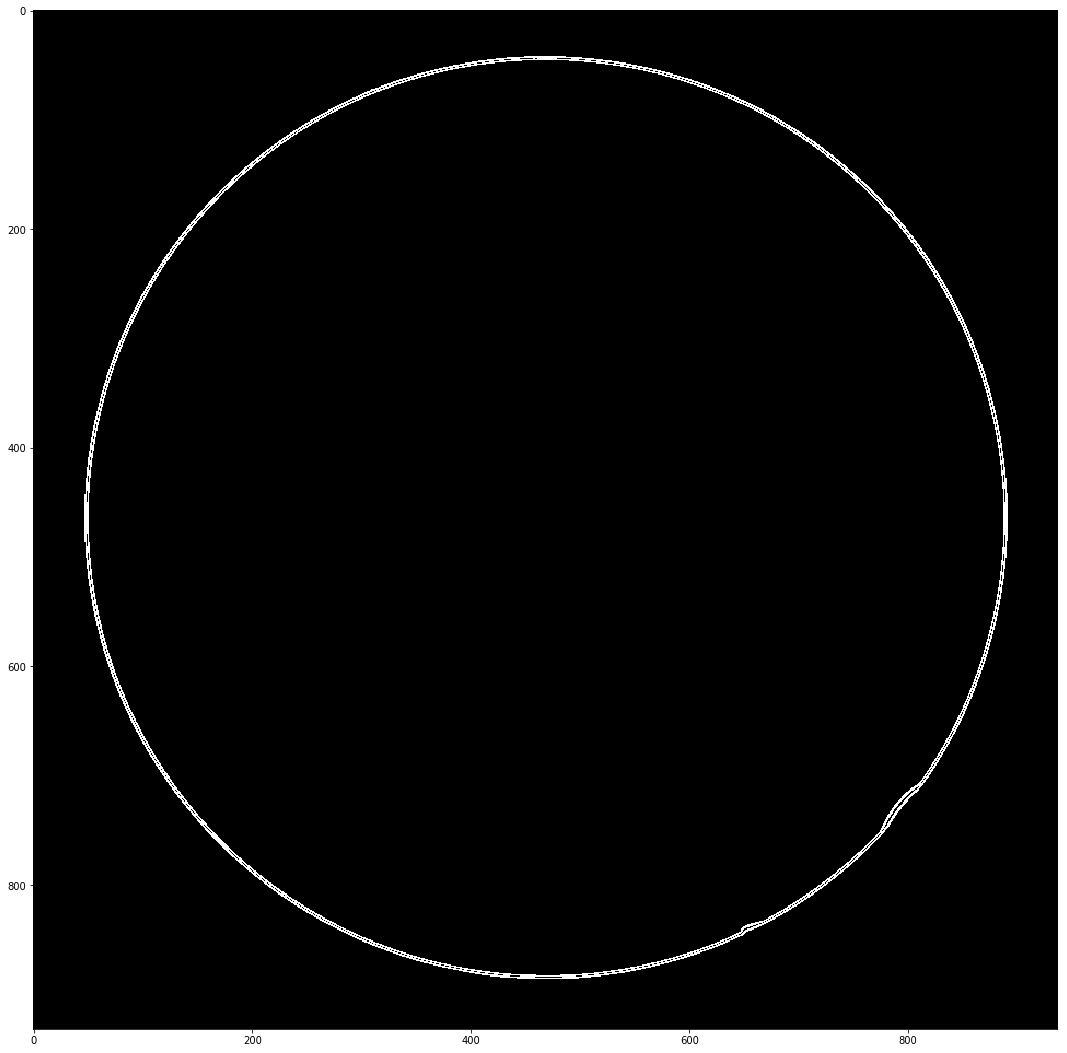

In [6]:
# Sobel filter
hxS = np.array([[1,2,1],[0,0,0],[-1, -2 ,-1]])*(1/8)
hyS = hxS.transpose()
dX2 = np.power(scipy.ndimage.filters.convolve(I, hxS),2)
dY2 = np.power(scipy.ndimage.filters.convolve(I, hyS),2)
J = defineImage(np.sqrt(dX2+ dY2))
K = enhanceImage(J)
(M,N) = K.shape
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(K,cmap=cm.gray,vmin=0,vmax=255)

(b).

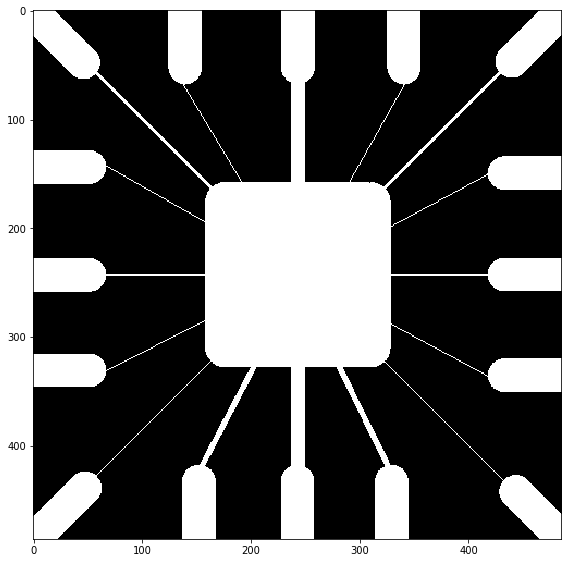

In [7]:
# reading original image
a = Image.open('Math386-HW2-Images/image-circuit.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

In [8]:
# laplacian filter
hL = np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]])

In [9]:
J = scipy.ndimage.filters.convolve(I, hL)

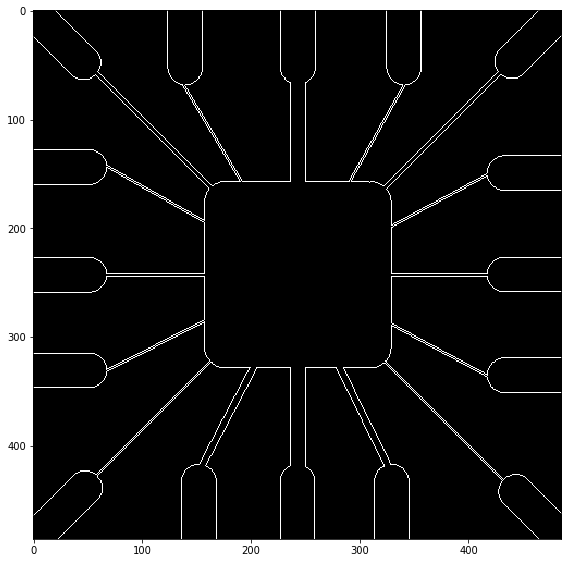

In [10]:
def defineImage(I):
    # prevent grey level values outside of [0, 255]
    return np.array([[max(0,min(255,j))for j in i] for i in I])

# extracting positive value and cap the maximal value as 255
J = defineImage(J)
(M,N) = I.shape
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)

**Why plotting positive values of laplacian of the image works on detecting the edges?**

The laplacian operation 'amplify' the color contrast on the edges, where the grey level changes the fastest, and he laplacian operation will result large numbers with opposite sign on two sides of the edge, and result zero or small number on the potins where color doesn't change or change slowly. Hence, taking only the positive numbers would also work. And taking absolute value would result in bolder lines in the laplacian modified image.

(c).

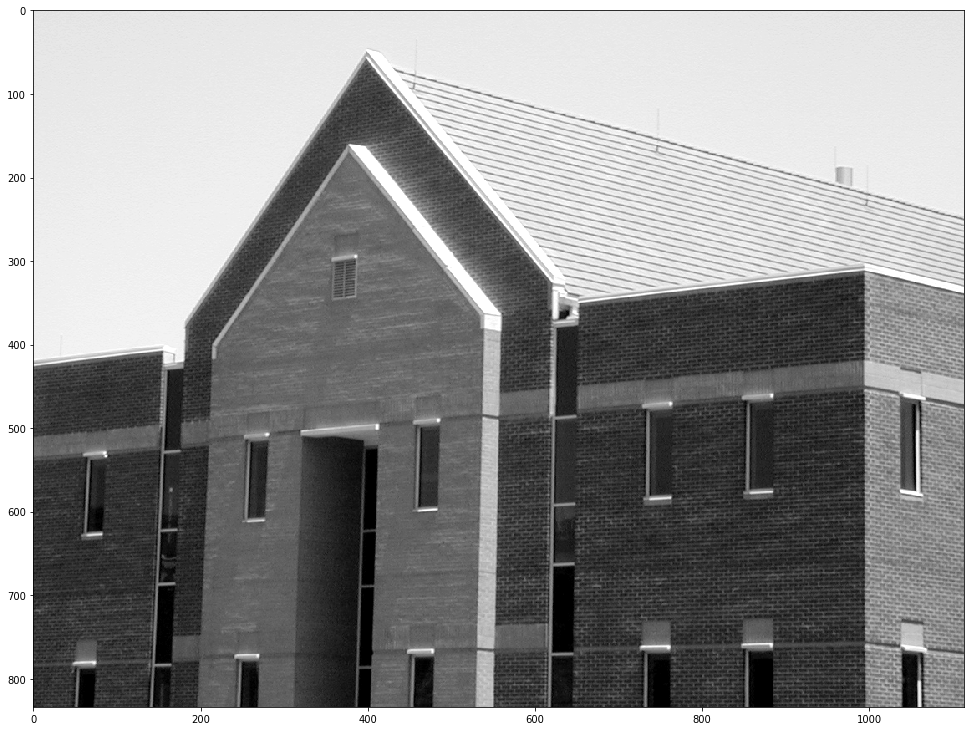

In [11]:
# reading original image
a = Image.open('Math386-HW2-Images/image-building.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

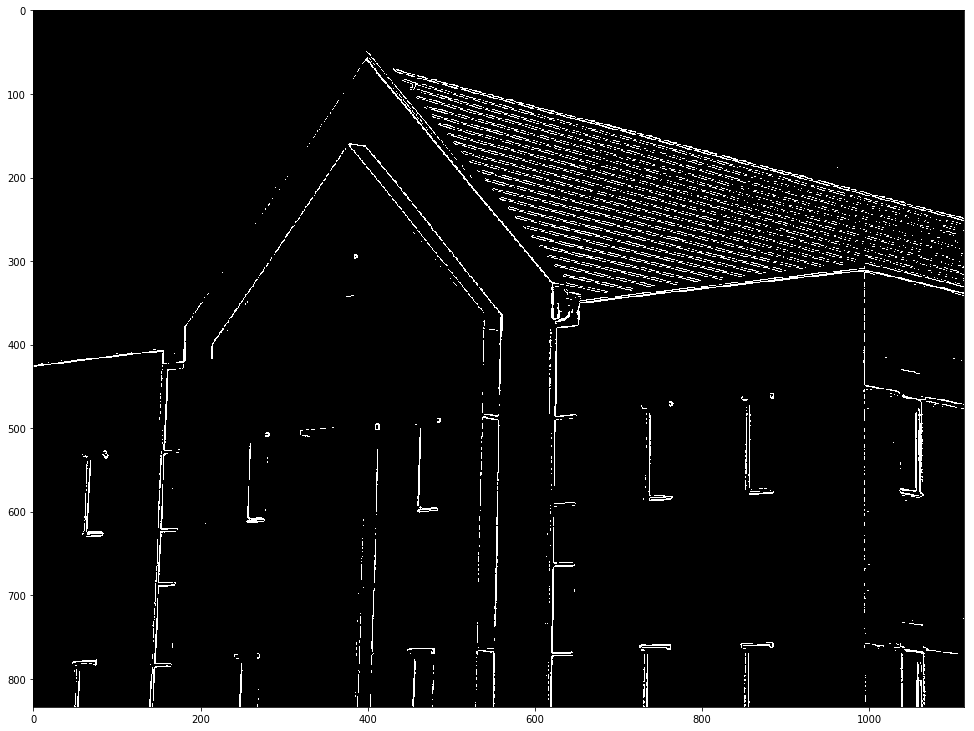

In [12]:
# Sobel filter
hxS = np.array([[1,2,1],[0,0,0],[-1, -2 ,-1]])*(1/8)
hyS = hxS.transpose()
dX2 = np.power(scipy.ndimage.filters.convolve(I, hxS),2)
dY2 = np.power(scipy.ndimage.filters.convolve(I, hyS),2)
J = defineImage(np.sqrt(dX2+ dY2))
K = enhanceImage(J)
(M,N) = K.shape
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(K,cmap=cm.gray,vmin=0,vmax=255)

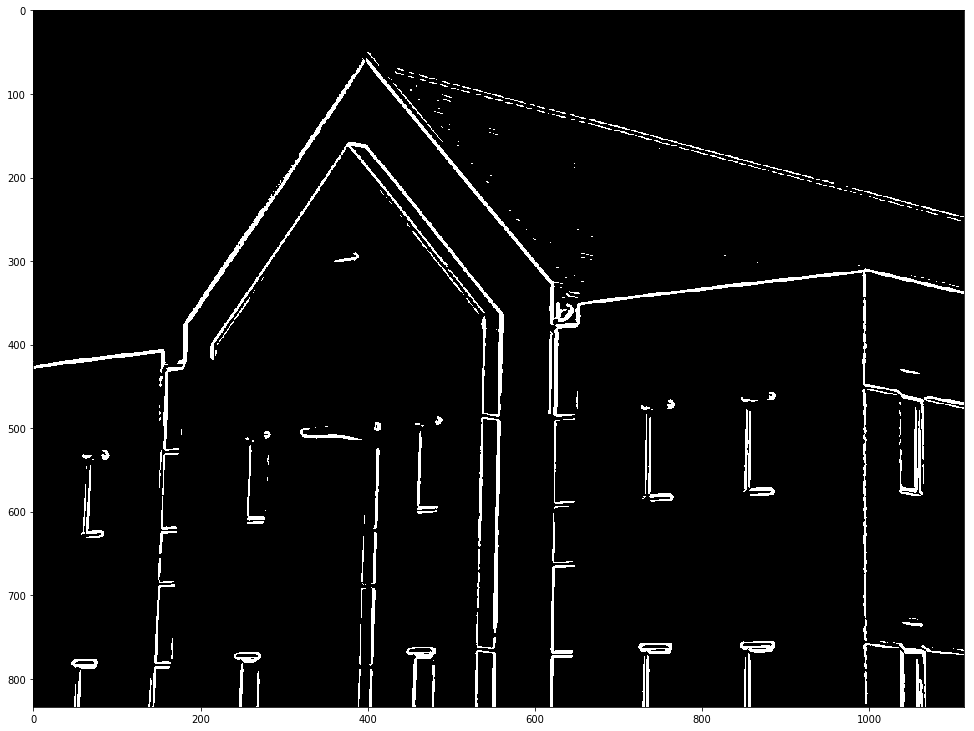

In [13]:
def defineImage(I):
    # prevent grey level values outside of [0, 255]
    return np.array([[max(0,min(255,j)) for j in i] for i in I])

def enhanceImage(I):
    # threshold of enhancement
    t = 0.33 * np.max(I)
    return np.array([[255 if c>t else 0 for c in r] for r in I], dtype=np.int32)

# step 1: smooth the image
# smoothing filter
hA = 1/25 * np.ones((5,5))
JA = scipy.ndimage.filters.convolve(I, hA)
# step 2: calculate gradiaent
# Sobel filter
hxS = np.array([[1,2,1],[0,0,0],[-1, -2 ,-1]])*(1/8)
hyS = hxS.transpose()
dX2 = np.power(scipy.ndimage.filters.convolve(JA, hxS),2)
dY2 = np.power(scipy.ndimage.filters.convolve(JA, hyS),2)
JG = defineImage(np.sqrt(dX2+ dY2))
# step 3: treshold the resulting image
K = enhanceImage(JG)
(M,N) = K.shape
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(K,cmap=cm.gray,vmin=0,vmax=255)

##### **Problem 2.4** (The Total Varition Norm)

##### **Answer:**

(a). for $v \in V$.

$$
||0|| = ||0\times v|| =|0|\times||v|| = 0
$$
$$
0 = ||0|| = || v + (-v)|| \le ||v|| + ||-v|| = 2||v|| \Rightarrow ||v||>0
$$

(b). for $v =(a, b), w = (c, d) \in R^2$

N1: 
$$
||av|| = \sqrt{a^2{x_1}^2+a^2{y_1}^2} = |a| \sqrt{x_1^2 + y_1^2} = |a|\times||v||
$$
N2: 
$$
||v+w||^2 = ||v||^2 + ||w||^2 + 2<v,w> \le ||v||^2 + ||w||^2 + 2||v||||w|| = (||v|| + ||w||)^2
$$
The inequality in above equation is from Cauchy–Schwarz inequality.

$\Rightarrow$
$$
||v+w|| = \le (||v|| + ||w||)
$$

N3:
$$
||v||=0 \Rightarrow \sqrt{a^2+b^2} =0 \Rightarrow a^2 =0 \& b^2=0 \Rightarrow a=0 \& b=0 \Rightarrow v= (0, 0)
$$

Hence the Euclidean norm in $R^2$ is a norm.

Then, let's proof the Total Variation Norm is a seminorm:
N1:
$$
||aI||_{TV} = \frac{1}{M\cdot N} \sum \sum ||\nabla a I|| dA = \frac{1}{M\cdot N} \sum \sum |a| ||\nabla I|| dA = |a| ||I||_{TV}
$$
N2: 

\begin{eqnarray}
|| I + J||_{TV} &= \frac{1}{M\cdot N} \sum \sum ||\nabla (I+J)|| dA\\
&=\frac{1}{M\cdot N} \sum \sum ||\nabla I+ \nabla J|| dA\\
&\le \frac{1}{M\cdot N} \sum \sum ||\nabla I|| dA + \frac{1}{M\cdot N} \sum \sum ||\nabla I|| dA\\
&= || I||_{TV} + ||J||_{TV}
\end{eqnarray}

However, the N3 property cannot be satisfied. Because $||I||_{TV} = 0$ doesn't mean the image $I$ has all zeros in each pixel. It only means there is no changes of grey level across both horizontal and vertical direction. Any image with constant grey level, which no necessary zero, has $||I||_{TV} = 0$;

(c).

In [14]:
def defineImage(I):
    # prevent grey level values outside of [0, 255]
    return np.array([[max(0,min(255,j)) for j in i] for i in I])

def getTotalVariationNorm(I):
    (M,N) = I.shape
    # Sobel filter
    hxS = np.array([[1,2,1],[0,0,0],[-1, -2 ,-1]])*(1/8)
    hyS = hxS.transpose()
    dX2 = np.power(scipy.ndimage.filters.convolve(I, hxS),2)
    dY2 = np.power(scipy.ndimage.filters.convolve(I, hyS),2)
    J = defineImage(np.sqrt(dX2+ dY2))
    return (np.sum(J))/(M*N)

##### **Problem 2.5** (More on sharpening)

##### **Anwser:**
(a).

The Total Variation Norm is:  2.42020237236


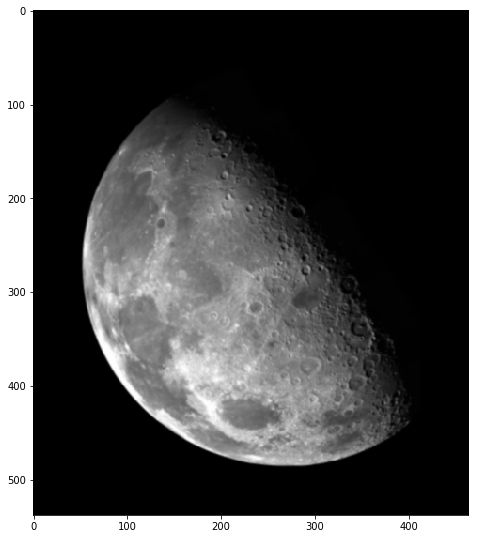

In [15]:
# reading original image
a = Image.open('Math386-HW2-Images/image-moon.jpg')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)
# total variation norm for original image
print('The Total Variation Norm is: ', getTotalVariationNorm(I))

The Total Variation Norm is:  2.60962474079


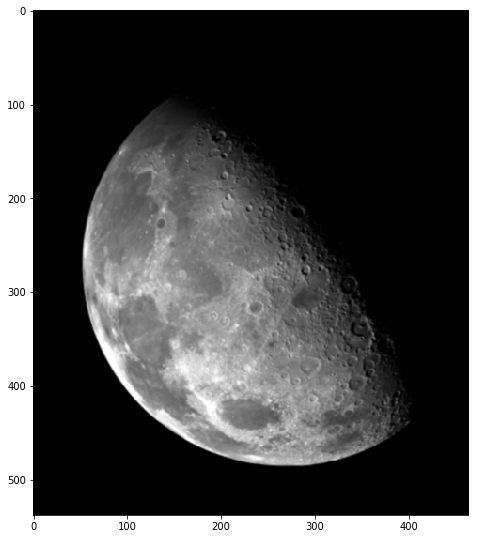

In [16]:
hL = np.array([
    [0,1,0],
    [1,-4,1],
    [0,1,0]])
hd = np.array([
    [0,0,0],
    [0,1,0],
    [0,0,0]])
k = 0.1
h = hd - k*hL
J = defineImage(scipy.ndimage.filters.convolve(I, h))
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
# total variation norm for sharppend image with k=0.1
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

The Total Variation Norm is:  4.51195683131


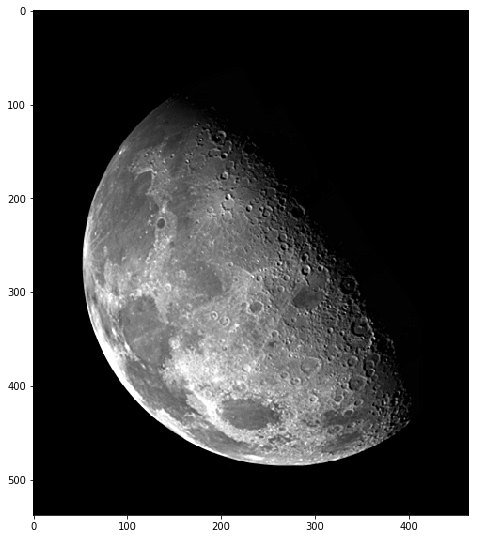

In [17]:
k = 1
h = hd - k*hL
J = defineImage(scipy.ndimage.filters.convolve(I, h))
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
# total variation norm for sharppend image with k=1
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

The Total Variation Norm is:  6.65812170627


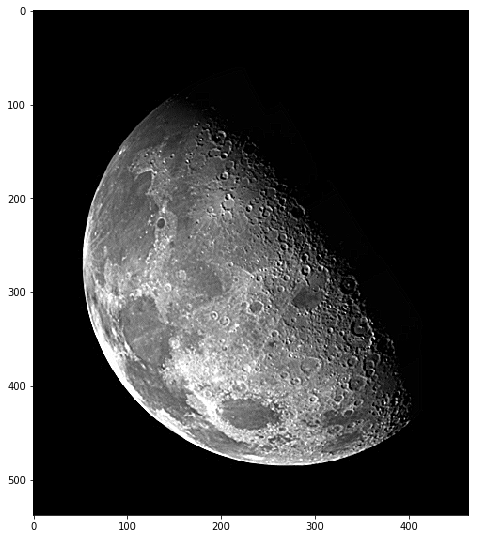

In [18]:
k = 2
h = hd - k*hL
J = defineImage(scipy.ndimage.filters.convolve(I, h))
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
# total variation norm for sharppend image with k=2
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

The Total Variation Norm is:  10.4659869965


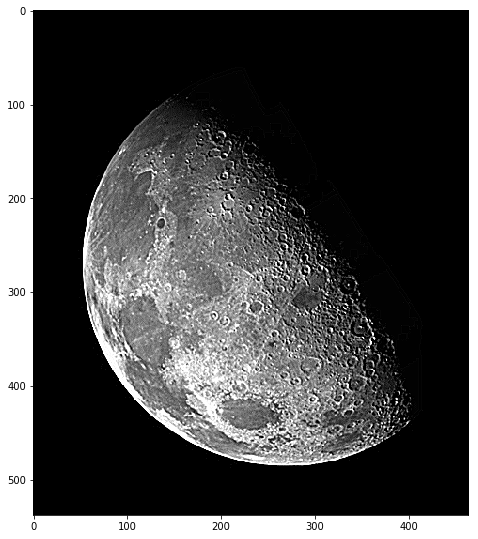

In [19]:
k = 4
h = hd - k*hL
J = defineImage(scipy.ndimage.filters.convolve(I, h))
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
# total variation norm for sharppend image with k=4
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

In [20]:
ks = np.linspace(0.1, 20, 10)
tvs = []
for k in ks:
    h = hd - k*hL
    J = defineImage(scipy.ndimage.filters.convolve(I, h))
    tvs.append(getTotalVariationNorm(J))

Text(0,0.5,'the total variation norm')

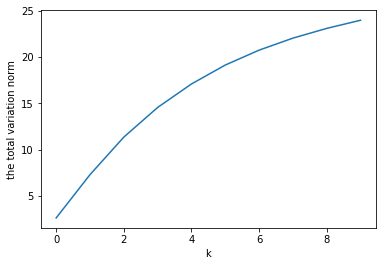

In [21]:
plt.plot(tvs)
plt.xlabel('k')
plt.ylabel('the total variation norm')

(b). 

The Total Variation Norm is:  8.1695179874


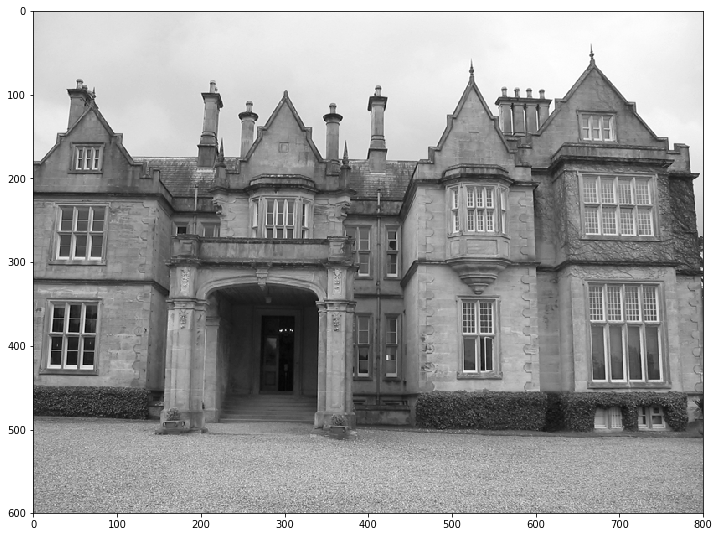

In [22]:
# reading original image
a = Image.open('Math386-HW2-Images/image-irish.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

print('The Total Variation Norm is: ', getTotalVariationNorm(I))

In [23]:
from math import exp
def unsharpMasking(I, a, sigma, n):
    
    def defineImage(I):
        # prevent grey level values outside of [0, 255]
        return np.array([[max(0,min(255,j)) for j in i] for i in I])
    
    def gaussian(x,y,sigma):
        return exp(-(x**2+y**2)/(2*sigma**2))

    _hM = np.array([[ gaussian(r, c, sigma) for c in range(int(-(n-1)/2),int((n-1)/2 + 1))] for r in range(int(-(n-1)/2),int((n-1)/2 + 1))])
    hM = _hM/np.sum(_hM)
#     hM = np.array([[0.0449, 0.1221, 0.0449],[0.1221, 0.3319, 0.1221],[0.0449, 0.1221, 0.0449]])
    hd = np.zeros((n,n))
    hd[int((n-1)/2), int((n-1)/2)] = 1
    hUM = (1+a)*hd - a*hM
    J = defineImage(scipy.ndimage.filters.convolve(I, hUM))  
    return J

The Total Variation Norm is:  9.58077430446


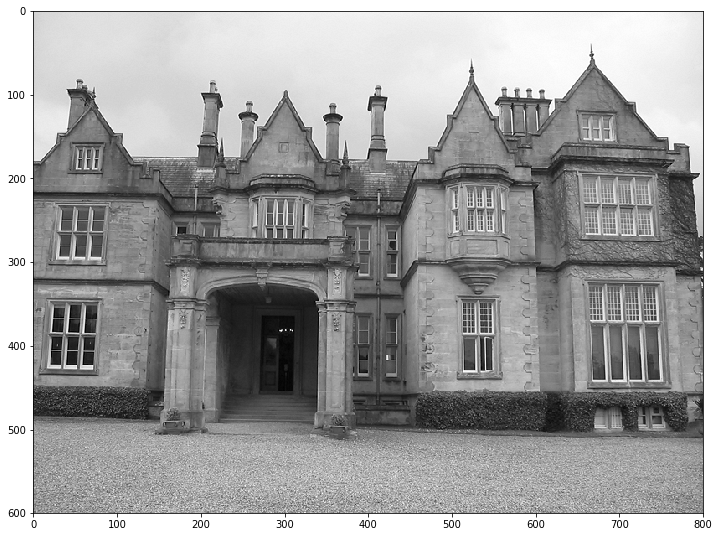

In [24]:
J = unsharpMasking(I, 1, 0.5, 3)
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

The Total Variation Norm is:  12.3709624686


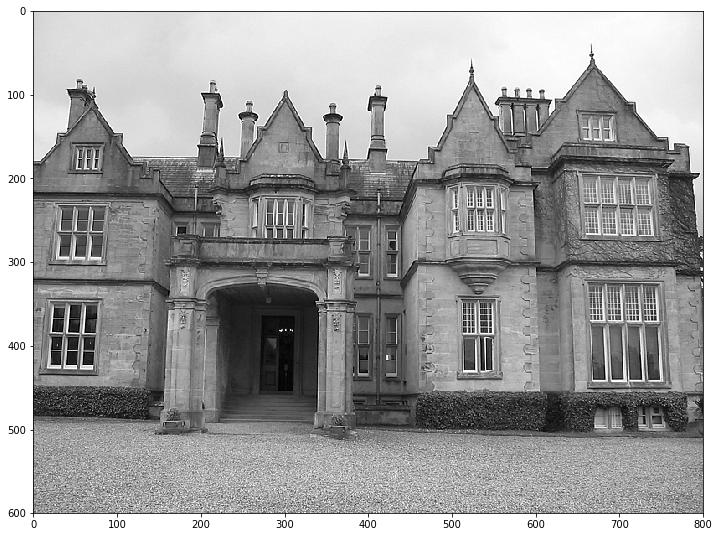

In [25]:
J = unsharpMasking(I, 1, 5, 3)
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

The Total Variation Norm is:  12.3802848283


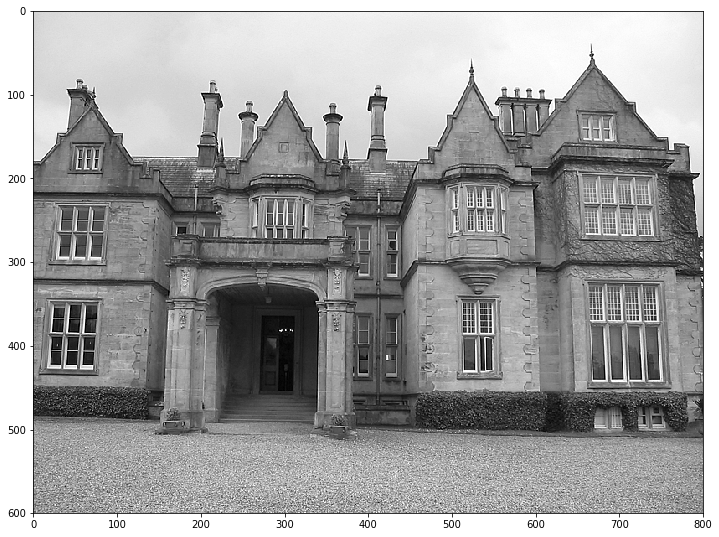

In [26]:
J = unsharpMasking(I, 1, 10, 3)
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)
print('The Total Variation Norm is: ', getTotalVariationNorm(J))

##### **Problem 2.6** (Detecting diagonal edges)

##### **Anwser:**

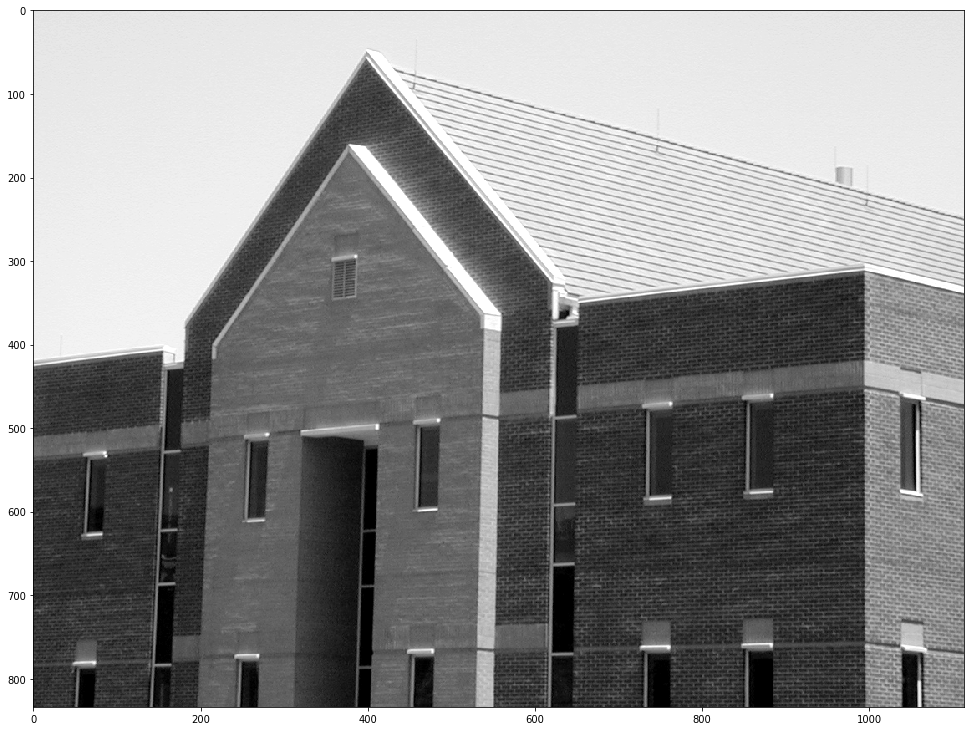

In [27]:
# reading original image
a = Image.open('Math386-HW2-Images/image-building.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

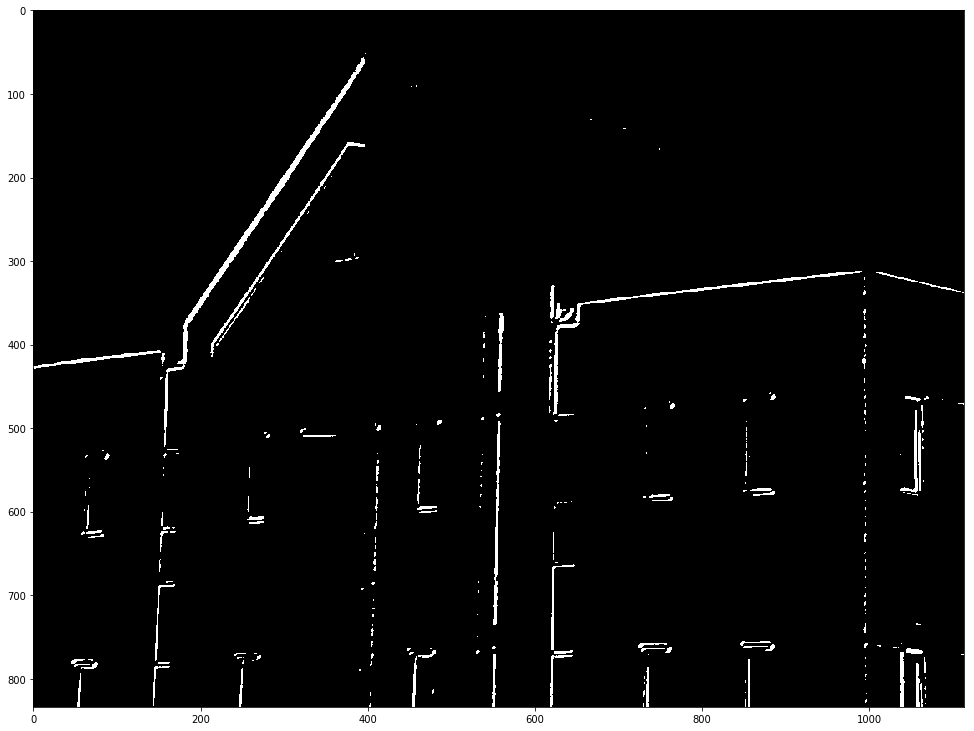

In [28]:
def defineImage(I):
    # prevent grey level values outside of [0, 255]
    return np.array([[max(0,min(255,j)) for j in i] for i in I])

def enhanceImage(I):
    # threshold of enhancement
    t = 0.33 * np.max(I)
    return np.array([[255 if c>t else 0 for c in r] for r in I], dtype=np.int32)

# step 1: smooth the image
# smoothing filter
hM = 1/25 * np.ones((5,5))
JM = scipy.ndimage.filters.convolve(I, hM)

# step 2: convolve with directional sobel filter
# Sobel filter
hnS = np.array([[2, 1, 0],[1, 0, -1],[0, -1, -2]])*(1/8)

JS = scipy.ndimage.filters.convolve(JA, hnS)

# step 3: compute the absolute value
JA = np.absolute(JS)

# step 3: treshold the resulting image
K = enhanceImage(JA)
(M,N) = K.shape
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(K,cmap=cm.gray,vmin=0,vmax=255)

**Highlight**: The edges along the vector $n = (1,1)/\sqrt 2$ direction is highlighted.

##### **Problem 2.7**

##### **Answer:**
Suppose that $g$, and $h$ are two convolution kernels with size $(2K_1 + 1) \times (2K_1 + 1)$ and $(2K_2 + 1) \times (2K_2 + 1)$, respectively, The size of the convolution kernel $f=g*h$ is $(2(K_1+K_2)+1) \times (2(K_1+K_2)+1)$.

Justification: because the size of a kernal determined by the farest non-zero pixels, which is the pixels at the four corners, to the central pixel. After applying convolution calculation with two different sized kernels, the farest pixels could have values would be $K_1 + K_2$ pixels away from central pixel along the diagnal and off-diagnal direction. 

##### **Problem 2.8** ( Image Equalization)

##### **Anwser:**

(a). a second pass of histogram equalization will not produce a different result. Becase the equalization operation can be treated as the rearange of the current grey level distribution, and once it is rearranged following the equalization rule, futher passes won't change the result.

(b).

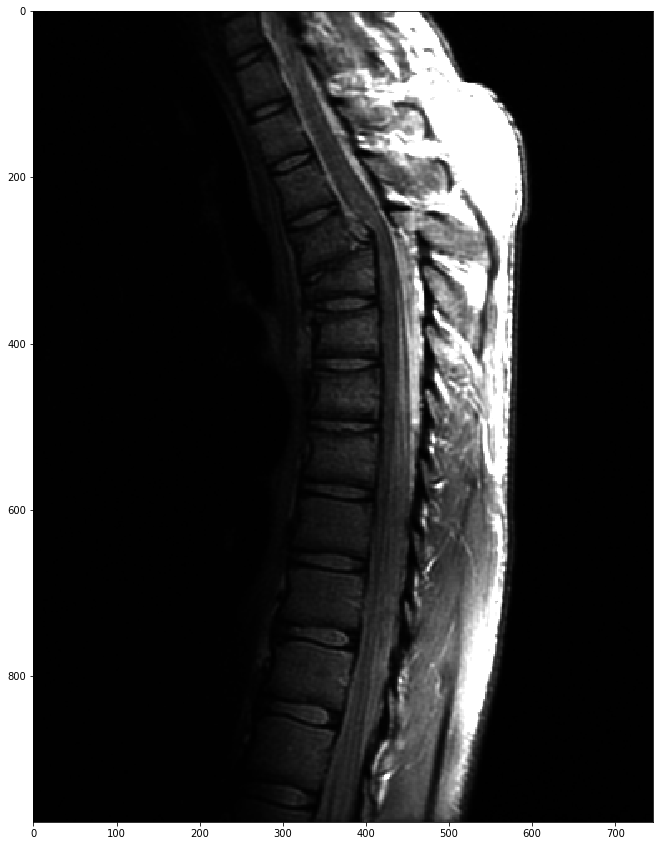

In [29]:
# reading original image
a = Image.open('Math386-HW2-Images/image-spine.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

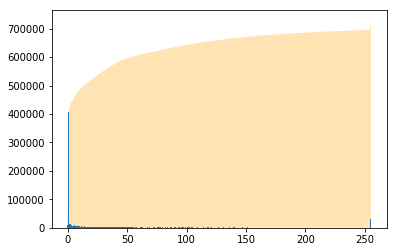

In [30]:
(pdf, x) = np.histogram(I,bins=np.arange(257))
cdf = np.cumsum(pdf)
plt.bar(x[:-1],pdf,width=1)
# plt.plot(x[:-1], cdf)
plt.fill_between(x[:-1], cdf, np.zeros(len(cdf)), facecolor='orange', alpha=0.3)


In [31]:
def equalizeImage(I):
    (M, N) = I.shape
    (pdf, x) = np.histogram(I,bins=np.arange(257))
    cdf = np.cumsum(pdf)
    J = np.zeros((M, N))
    L = 256
    for i in range(M):
        for j in range(N):
            J[i,j] = cdf[int(I[i,j])]*(L-1)/M/N
    return J

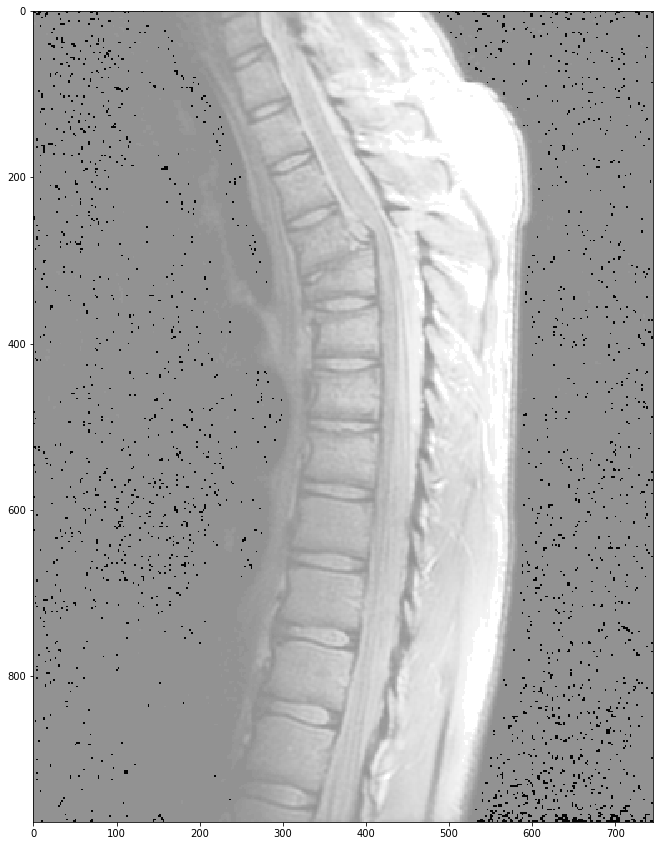

In [32]:
J = equalizeImage(I)
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)

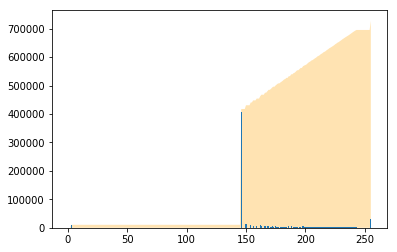

In [33]:
(pdf, x) = np.histogram(J,bins=np.arange(257))
cdf = np.cumsum(pdf)
plt.bar(x[:-1],pdf,width=1)
# plt.plot(x[:-1], cdf)
plt.fill_between(x[:-1], cdf, np.zeros(len(cdf)), facecolor='orange', alpha=0.3)


(c).

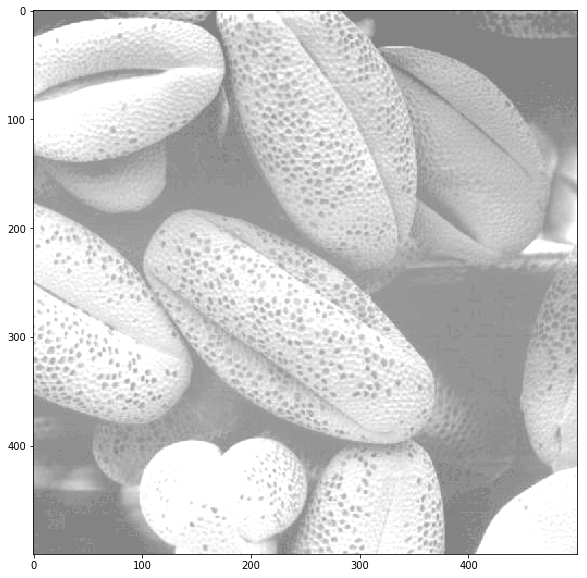

In [34]:
# reading original image
a = Image.open('Math386-HW2-Images/image-fruits.tif')
I = np.asarray(a, dtype=np.int32)
(M,N) = I.shape
# ploting image
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(I,cmap=cm.gray,vmin=0,vmax=255)

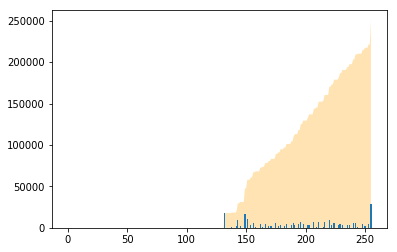

In [35]:

(pdf, x) = np.histogram(I,bins=np.arange(257))
cdf = np.cumsum(pdf)
plt.bar(x[:-1],pdf,width=1)
# plt.plot(x[:-1], cdf)
plt.fill_between(x[:-1], cdf, np.zeros(len(cdf)), facecolor='orange', alpha=0.3)

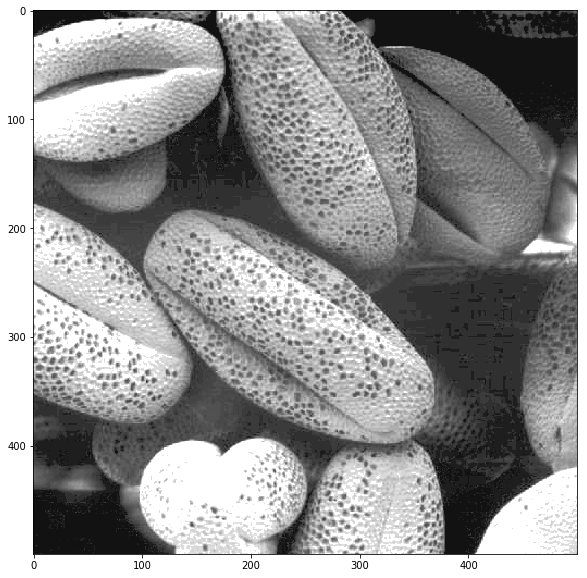

In [36]:
J = equalizeImage(I)
plt.figure(1,figsize=(M/50,N/50))
fig1 = plt.imshow(J,cmap=cm.gray,vmin=0,vmax=255)

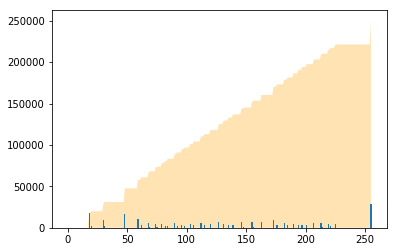

In [37]:
(pdf, x) = np.histogram(J,bins=np.arange(257))
cdf = np.cumsum(pdf)
plt.bar(x[:-1],pdf,width=1)
# plt.plot(x[:-1], cdf)
plt.fill_between(x[:-1], cdf, np.zeros(len(cdf)), facecolor='orange', alpha=0.3)
